## COMP5625M Assessment 2 - Image Caption Generation [100 marks]

<div class="logos"><img src="./Comp5625M_logo.jpg" width="220px" align="right"></div>

The maximum marks for each part are shown in the section headers. The overall assessment carries a total of 100 marks.

This assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this assessment, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image-to-text model.
> 3. Use and compare two text similarity metrics for evaluating an image-to-text model, and understand evaluation challenges.


### Setup and resources 

Having a GPU will speed up the image feature extraction process. If you want to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using PyTorch and Python-based libraries, and refer to the notebooks and exercises provided.

This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each with five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H). 

``Info only:`` To understand more about the COCO dataset, you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)", but our image subset consists of fewer images than the original COCO dataset. **So, no need to download anything from here!** 

> 2. **Image metadata**: as our set is a subset of the full COCO dataset, we have created a CSV file containing relevant metadata for our particular subset of images. You can also download it from Drive, "coco_subset_meta.csv", at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format. **Do not change the file name.**
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) are displayed in the .html for marking.

**Final note:**

> **Please include everything you would like to be marked in this notebook, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the appropriate section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):

sc22krm

Your full name:

Karthik Reddy Maregowdara

### Imports

Feel free to add to this section as needed.

In [3]:
import zipfile as zf
files = zf.ZipFile("COMP5625M_data_assessment_2.zip", 'r')
files.extractall('directory to extract')
files.close()

In [95]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import DataLoader
import os
import numpy as np
import re

Detect which device (CPU/GPU) to use.

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last convolutional layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

**(Hint)** You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you finetuned to COCO dataset. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer* to speed up training. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use **RNN** in this assessment). 

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) --> 


<div>
<center><img src="comp5625M_figure_imageCaption.jpg" width="1000"/></center>
</div>


The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the **training more efficient by decoupling the networks**. Thus, we will:

> First extract the feature representations of the images from the Encoder

> Save these features (Part 1) such that during the training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

**Hint**
Try commenting out the feature extraction part once you have saved the embeddings. This way if you have to re-run the entire codes for some reason then you can only load these features. 


### Overview

> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity


## 1 Extracting image features [11 marks]

> 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> 1.2 Image feature extraction step (7 marks)

#### 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> Read through the template EncoderCNN class below and complete the class.

> You are expected to use ResNet50 pretrained on imageNet provided in the Pytorch library (torchvision.models)


In [97]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        # Your code here!

         # Load the pretrained ResNet-50
        resnet = models.resnet50(pretrained=True)
        
        # Remove the last fully-connected layer
        modules = list(resnet.children())[:-1]
        
        # Create the new ResNet without the last layer
        self.resnet = nn.Sequential(*modules)

        
    def forward(self, images):
        """Extract feature vectors from input images."""

        # Pass the images through the ResNet and disable gradients calculation
        with torch.no_grad():
            features = self.resnet(images)
        
        # Reshape the features to be suitable for the decoder
        features = features.view(features.size(0), -1)
        
        return features


In [7]:
# instantiate encoder and put into evaluation mode.
# Your code here!
encoder = EncoderCNN()
encoder.eval()

/Users/karthikuni/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/karthikuni/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

#### 1.2 Image feature extraction step (7 marks)

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [98]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224, antialias= True), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [99]:
# Get unique images from the csv for extracting features - helper code
imageList = pd.read_csv("coco_subset_meta.csv")
imageList['file_name']
len(imageList.id.unique())

imagesUnique = sorted(imageList['file_name'].unique())
print(len(imagesUnique))

df_unique_files =  pd.DataFrame.from_dict(imagesUnique)

df_unique_files.columns = ['file_name']
df_unique_files

5068


,file_name
0,000000000009.jpg
1,000000000025.jpg
2,000000000030.jpg
3,000000000034.jpg
4,000000000036.jpg
...,...
5063,000000581906.jpg
5064,000000581909.jpg
5065,000000581913.jpg
5066,000000581921.jpg


In [15]:
# Define a class COCOImagesDataset(Dataset) function that takes the 
# image file names and reads the image and apply transform to it
# ---> your code here! we have provided you a sketch 

IMAGE_DIR = "coco/images/"

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform=transform
        

    def __getitem__(self, index):
        filename = self.df.iloc[index]['file_name']
        img_path = os.path.join(IMAGE_DIR, filename)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform is not None:
            image=self.transform(image)
        
        # --> your code here!
        
        return image, filename

    def __len__(self):
        return len(self.df)
    

In [20]:
# Use Dataloader to use the unique files using the class COCOImagesDataset
# make sure that shuffle is False as we are not aiming to retrain in this exercise
# Your code here-->
from torch.utils.data import DataLoader
dataset = COCOImagesDataset(df_unique_files, transform=data_transform)
# create data loader object
batch_size=64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [100]:
# Apply encoder to extract featues and save them (e.g., you can save it using image_ids)
# Hint - make sure to save your features after running this - you can use torch.save to do this
features_map = dict()
from tqdm.notebook import tqdm

# Move the encoder to the appropriate device
encoder = encoder.to(device)

# Use the encoder to extract features and save them
with torch.no_grad():
    for images, filenames in tqdm(dataloader):
        # Move images to the appropriate device
        images = images.to(device)
        
        # Extract features using the encoder
        features = encoder(images)
        
        # Save the features in the features_map dictionary using filenames as keys
        for i, filename in enumerate(filenames):
            features_map[filename] = features[i].cpu().numpy()
""""features_map = dict()
from tqdm.notebook import tqdm
from PIL import Image

with torch.no_grad():
    for images, filenames in tqdm(dataloader):
        # move images to device
        images = images.to(device)
        # extract features
        features = encoder(images)
        # move features to cpu
        features = features.cpu().numpy()
        # save features
        for feature, filename in zip(features, filenames):
            features_map[filename] = feature
    # save features to file
    torch.save(features_map, 'features.pt')"""
# ---> Your code here!  





  0%|          | 0/80 [00:00<?, ?it/s]

'"features_map = dict()\nfrom tqdm.notebook import tqdm\nfrom PIL import Image\n\nwith torch.no_grad():\n    for images, filenames in tqdm(dataloader):\n        # move images to device\n        images = images.to(device)\n        # extract features\n        features = encoder(images)\n        # move features to cpu\n        features = features.cpu().numpy()\n        # save features\n        for feature, filename in zip(features, filenames):\n            features_map[filename] = feature\n    # save features to file\n    torch.save(features_map, \'features.pt\')'

In [102]:
torch.save(features_map,'features.pt')
loadfeatures_map = torch.load('features.pt')
print(loadfeatures_map)

{'000000000009.jpg': array([0.10355841, 0.87075186, 0.27453536, ..., 0.43302226, 0.934288  ,
       0.5164456 ], dtype=float32), '000000000025.jpg': array([0.23237883, 0.42780957, 0.35720384, ..., 0.29693216, 0.41374677,
       0.45107806], dtype=float32), '000000000030.jpg': array([0.1650165 , 0.11594609, 1.3275605 , ..., 0.20767488, 0.6530738 ,
       0.77147496], dtype=float32), '000000000034.jpg': array([0.444854  , 0.3418551 , 0.29564574, ..., 0.06837232, 0.3873233 ,
       0.23497109], dtype=float32), '000000000036.jpg': array([0.23413754, 0.75397867, 0.45076284, ..., 0.532048  , 0.17134959,
       0.00974581], dtype=float32), '000000000042.jpg': array([0.7357398, 1.4074576, 0.3709564, ..., 0.3534308, 1.3182114,
       1.1936929], dtype=float32), '000000000049.jpg': array([0.1654068 , 1.0586913 , 1.1552117 , ..., 0.0775959 , 0.19963095,
       0.35118747], dtype=float32), '000000000061.jpg': array([0.2182876 , 0.07983459, 0.2778038 , ..., 0.06656678, 0.2635385 ,
       0.71624213

## 2 Text preparation [23 marks]

> 2.1 Build the caption dataset (3 Marks)

> 2.2 Clean the captions (3 marks)

> 2.3 Split the data (3 marks)

> 2.4 Building the vocabulary (10 marks)

> 2.5 Prepare dataset using dataloader (4 marks)


#### 2.1 Build the caption dataset (3 Marks)

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="caption_image_ids.png" alt="images matched to caption" width="700"/>

In [103]:
import json

# loading captions for training
with open('coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])
df.shape

(591753, 3)

In [104]:
df_filter = df[df['image_id'] == 57429]
df_filter

,image_id,id,caption
69,57429,2049,An airplane with its landing wheels out landing.
74,57429,2139,A plane that is taking off at an airport
100,57429,2946,A man takes a picture of an airplane taking off.
189,57429,5520,A large jet takes off from an airport runway.
28393,57429,821117,The airplane is taking off on the runway at th...


In [105]:
# Hint: get the filename matching id from coco_subset_meta.csv - make sure that for each id you add image filename

# --> your code here! - name the new dataframe as "new_file"


# convert the annotations to a pandas dataframe
df = pd.DataFrame.from_dict(data['annotations'])

# load the image metadata
coco_subset = pd.read_csv('coco_subset_meta.csv')

# merge the two dataframes 
merge_df = df.merge(coco_subset, left_on='image_id', right_on='id')
merge_df


,image_id,id_x,caption,Unnamed: 0,license,file_name,coco_url,height,width,date_captured,flickr_url,id_y
0,57429,2049,An airplane with its landing wheels out landing.,433,3,000000057429.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-16 12:15:26,http://farm9.staticflickr.com/8130/8837554799_...,57429
1,57429,2139,A plane that is taking off at an airport,433,3,000000057429.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-16 12:15:26,http://farm9.staticflickr.com/8130/8837554799_...,57429
2,57429,2946,A man takes a picture of an airplane taking off.,433,3,000000057429.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-16 12:15:26,http://farm9.staticflickr.com/8130/8837554799_...,57429
3,57429,5520,A large jet takes off from an airport runway.,433,3,000000057429.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-16 12:15:26,http://farm9.staticflickr.com/8130/8837554799_...,57429
4,57429,821117,The airplane is taking off on the runway at th...,433,3,000000057429.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-16 12:15:26,http://farm9.staticflickr.com/8130/8837554799_...,57429
...,...,...,...,...,...,...,...,...,...,...,...,...
40008,180285,829636,"Two women smiling together, one holds a stuffe...",7717,2,000000180285.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-24 15:20:21,http://farm3.staticflickr.com/2554/4165824109_...,180285
40009,180285,829653,Two women smile for the camea while posing iwt...,6744,2,000000180285.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-24 15:20:21,http://farm3.staticflickr.com/2554/4165824109_...,180285
40010,180285,829653,Two women smile for the camea while posing iwt...,7717,2,000000180285.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-24 15:20:21,http://farm3.staticflickr.com/2554/4165824109_...,180285
40011,180285,829665,Two women sit and pose with stuffed animals.,6744,2,000000180285.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-24 15:20:21,http://farm3.staticflickr.com/2554/4165824109_...,180285


#### 2.2 Clean the captions (3 marks)

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed. 

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.


<img src="cleancaptions.png" alt="images matched to caption" width="700"/>

In [106]:
import re
merge_df["clean_caption"] = "" # add a new column to the dataframe for the cleaned captions

def gen_clean_captions_df(caption):

    # -->your code here
     # Remove spaces at the beginning and the end
    caption = caption.strip()
    
    # Convert to lower case
    caption = caption.lower()
    
    # Replace all non-alphabet characters with a space
    caption = re.sub(r'[^a-zA-Z]+', ' ', caption)
    
    # Replace all continuous spaces with a single space
    caption = re.sub(r'\s+', ' ', caption)
    
    return caption

In [107]:
# clean and print 10 of these
# Create a new feature 'processed_caption' in the DataFrame
merge_df['clean_caption'] = merge_df['caption'].apply(gen_clean_captions_df)

specified_feature = ['image_id','id_y','caption','file_name','clean_caption']

Specified_df= merge_df[specified_feature]
# Check the resulting DataFrame
print(Specified_df.head(10)) 


   image_id    id_y                                            caption  \
0     57429   57429  An airplane with its landing wheels out landing.    
1     57429   57429           A plane that is taking off at an airport   
2     57429   57429   A man takes a picture of an airplane taking off.   
3     57429   57429      A large jet takes off from an airport runway.   
4     57429   57429  The airplane is taking off on the runway at th...   
5    410627  410627  The young man is stirring his pot of food with...   
6    410627  410627                 A man enjoys cooking food in a pan   
7    410627  410627           A smiling man is cooking in his kitchen.   
8    410627  410627      A man smiles as he stirs his food in the pot.   
9    410627  410627        A boy smiles while holding a pot and spoon.   

          file_name                                      clean_caption  
0  000000057429.jpg   an airplane with its landing wheels out landing   
1  000000057429.jpg           a plane t

In [108]:
# clean and print 10 of these
#new_file = gen_clean_captions_df(new_file)
#new_file.head(10)

#### 2.3  Split the data (3 marks)

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [109]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """

    # Make a copy of the input list and shuffle it
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    # Determine the number of images in each split
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)

    # Return the splits
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [110]:

training_id, validation_id, test_id= split_ids(Specified_df['image_id'].unique())
df_train = Specified_df[Specified_df['image_id'].isin(training_id)]
df_validation = Specified_df[Specified_df['image_id'].isin(validation_id)]
df_test = Specified_df[Specified_df['image_id'].isin(test_id)]




In [111]:
print(len(training_id))
print(len(test_id))
print(len(validation_id))

3547
1015
506


In [112]:
print(len(df_train))
print(len(df_validation))
print(len(df_test))

28363
3829
7821


In [113]:
training_validation=np.concatenate((training_id, validation_id))


In [114]:

df_train



,image_id,id_y,caption,file_name,clean_caption
0,57429,57429,An airplane with its landing wheels out landing.,000000057429.jpg,an airplane with its landing wheels out landing
1,57429,57429,A plane that is taking off at an airport,000000057429.jpg,a plane that is taking off at an airport
2,57429,57429,A man takes a picture of an airplane taking off.,000000057429.jpg,a man takes a picture of an airplane taking off
3,57429,57429,A large jet takes off from an airport runway.,000000057429.jpg,a large jet takes off from an airport runway
4,57429,57429,The airplane is taking off on the runway at th...,000000057429.jpg,the airplane is taking off on the runway at th...
...,...,...,...,...,...
40008,180285,180285,"Two women smiling together, one holds a stuffe...",000000180285.jpg,two women smiling together one holds a stuffed...
40009,180285,180285,Two women smile for the camea while posing iwt...,000000180285.jpg,two women smile for the camea while posing iwt...
40010,180285,180285,Two women smile for the camea while posing iwt...,000000180285.jpg,two women smile for the camea while posing iwt...
40011,180285,180285,Two women sit and pose with stuffed animals.,000000180285.jpg,two women sit and pose with stuffed animals


#### 2.4 Building the vocabulary (10 marks)

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [115]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [116]:
# [Hint] building a vocab function such with frequent words e.g., setting MIN_FREQUENCY = 3
MIN_FREQUENCY = 3

def build_vocab(df_ids, new_file):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    # for index in df.index:
    for index, id in enumerate(df_ids):
        caption = str(new_file.loc[new_file['image_id']==id]['clean_caption'])
        for word in caption.split():
            # also get rid of numbers, symbols etc.
            if word in word_mapping:
                word_mapping[word] += 1
            else:
                word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()
    # print(type(word_mapping))

    # print(Counter(word_mapping))
    print('Word Mapping size : '+ str(len(word_mapping)))
    # add the words to the vocabulary
    for word, count in word_mapping.items():
        # Ignore infrequent words to reduce the embedding size
        if count > MIN_FREQUENCY:
            vocab.add_word(word)
    return vocab


In [117]:
# build your vocabulary for train, valid and test sets
# ---> your code here!

trainingvocab = build_vocab(df_train['image_id'].tolist(), df_train)
validationvocab = build_vocab(df_validation['image_id'].tolist(), df_validation)
testvocab = build_vocab(df_test['image_id'].tolist(), df_test)
train_val_vocab= build_vocab(training_validation, Specified_df)

# Build the vocabulary for the training set


print(len(trainingvocab))
print(len(testvocab))
print(len(train_val_vocab))




Word Mapping size : 35595
Word Mapping size : 6428
Word Mapping size : 11612
Word Mapping size : 39911
35598
11615
3397


#### 2.5 Prepare dataset using dataloader (4 marks)

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 2048).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [118]:
MAX_SEQ_LEN = 47

class COCO_Features(Dataset):
    """COCO subset custom dataset, compatible with torch.utils.data.DataLoader."""

    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper
        """
        self.df = df
        self.features = features
        self.vocab = vocab

        self.image_id_list = df["image_id"].unique()  # list of unique image IDs in the COCO subset dataframe
        self.df.reset_index(drop=True, inplace=True)  # reset index of the COCO subset dataframe
        

    def __getitem__(self, index):
        """Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length)"""

        image_id = self.df.iloc[index]['image_id']
        feature = self.features[image_id]
        caption = self.df.iloc[index]['clean_caption']
        
        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption_ids = [self.vocab(token) for token in tokens] + [self.vocab('<end>')]
        caption_length = len(caption_ids)
        
        # Add padding
        while len(caption_ids) < MAX_SEQ_LEN:
            caption_ids.append(self.vocab('<pad>'))

        return torch.Tensor(feature).unsqueeze(0), torch.LongTensor(caption_ids), torch.LongTensor([caption_length])
    

    def __len__(self):
        return len(self.df)


In [119]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: x[2], reverse=True)
    images, captions, lengths = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    # If using features, 2D tensor to 3D tensor (batch_size, 256).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    targets = torch.stack(captions, 0)

    # Pad with zeros.
    # Since the captions are already padded in the Dataset class, no additional padding is needed here.

    return images, targets, lengths


In [120]:
filename_to_id = {row['file_name']: row['id'] for _, row in coco_subset.iterrows()}


# features_map = dict()
loadfeatures_map = {filename_to_id[filename]: feature for filename, feature in loadfeatures_map.items()}

In [121]:
#filename_id = {row['file_name']: row['id'] for _, row in coco_subset.iterrows()}
#loadfeatures_map = {filename_id[filename]: feature for filename, feature in loadfeatures_map.items() if filename in filename_id}

#filename_id = {row['file_name']: row['id'] for _, row in coco_subset.iterrows()}


# features_map = dict()
#loadfeatures_map = {filename_id[filename]: feature for filename, feature in loadfeatures_map.items() if filename in filename_id}

#loadfeatures_map = {filename_id[filename]: feature for filename, feature in loadfeatures_map.items()}

In [122]:
training_image_ids = set(df_train["image_id"].unique())
validation_image_ids = set(df_validation["image_id"].unique())
testing_image_ids = set(df_test["image_id"].unique())

loadimage_ids = set(loadfeatures_map.keys())

training_image_ids_filtered = training_image_ids.intersection(loadimage_ids)
validation_image_ids_filtered = validation_image_ids.intersection(loadimage_ids)
testing_image_ids_filtered = testing_image_ids.intersection(loadimage_ids)

train_df_filtered = df_train[df_train["image_id"].isin(training_image_ids_filtered)]
valid_df_filtered = df_validation[df_validation["image_id"].isin(validation_image_ids_filtered)]
test_df_filtered = df_test[df_test["image_id"].isin(testing_image_ids_filtered)]

print("Training_df_filtered length:", len(train_df_filtered))
print("Valid_df_filtered length:", len(valid_df_filtered))
print("Test_df_filtered length:", len(test_df_filtered))

print("Unique image IDs in Train:", len(training_image_ids_filtered))
print("Unique image IDs in Validation:", len(validation_image_ids_filtered))
print("Unique image IDs in Test:", len(testing_image_ids_filtered))

print(len(train_val_vocab))

Training_df_filtered length: 28363
Valid_df_filtered length: 3829
Test_df_filtered length: 7821
Unique image IDs in Train: 3547
Unique image IDs in Validation: 506
Unique image IDs in Test: 1015
3397


In [123]:
 
# Creating train DataLoader
dataset_train = COCO_Features(
    df=train_df_filtered,
    features=loadfeatures_map,
    vocab=train_val_vocab,
)

dataloader_training = DataLoader(
    dataset=dataset_train,
    batch_size=64,
    shuffle=True,
    collate_fn=caption_collate_fn,
)

# Creating validation DataLoader
dataset_valid = COCO_Features(
    df=valid_df_filtered,
    features=loadfeatures_map,
    vocab=train_val_vocab,
)

dataloader_validation = DataLoader(
    dataset=dataset_valid,
    batch_size=64,
    shuffle=False,
    collate_fn=caption_collate_fn,
)



# Creating test DataLoader
dataset_test = COCO_Features(
    df=test_df_filtered,
    features=loadfeatures_map,
    vocab=train_val_vocab,
)

dataloader_test = DataLoader(
    dataset=dataset_test,
    batch_size=64,
    shuffle=False,
    collate_fn=caption_collate_fn,
)


In [124]:
print("Length of training dataset:", len(dataset_train))
print("Length of training dataframe:", len(train_df_filtered))
print("Length of validation dataset:", len(dataset_valid))
print("Length of validation dataframe:", len(valid_df_filtered))

Length of training dataset: 28363
Length of training dataframe: 28363
Length of validation dataset: 3829
Length of validation dataframe: 3829


Load one batch of the training set and print out the shape of each returned Tensor.

In [125]:
# Create an iterator for the training DataLoader
train_iterator = iter(dataloader_training)
print(type(train_iterator))

# Fetch the first batch from the iterator
images_batch, captions_batch, lengths_batch = next(train_iterator)

print(f"Image features batch shape: {images_batch.shape}")
print(f"Captions batch shape: {captions_batch.shape}")
print(f"Caption lengths batch shape: {len(lengths_batch)}")
len(dataloader_training)

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
Image features batch shape: torch.Size([64, 1, 2048])
Captions batch shape: torch.Size([64, 47])
Caption lengths batch shape: 64


444

## 3 Train DecoderRNN [20 marks]

> 3.1 Design RNN-based decoder (10 marks)

> 3.2 Train your model with precomputed features (10 Marks)

#### 3.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```RNN``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [126]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last convolutional layer (flattened to dimensions after AdaptiveAvgPool2d that may give you => 1 x 1 x 2048, other layers are also accepted but this will affect your accuracy!)
        # into a Linear layer to resize
        self.resize = nn.Linear(2048, embed_size)
        
        # batch normalization helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        # RNN layer
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)

        # linear layer to map the hidden state of RNN to vocabulary space
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        self.max_seq_length = max_seq_length

    def forward(self, features, captions, lengths):
        
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
      # resize and normalize image features
      # im_features = self.resize(features)
        im_features = self.resize(features).view(features.size(0), -1)
        im_features = im_features.view(im_features.size(0), -1)
        im_features = self.bn(im_features)
      # concatenate image and text embeddings
        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)
      # pack embeddings
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
      # pass through RNN
        hiddens, _ = self.rnn(packed)
      # unpack hidden states and pass through linear layer
        outputs = self.linear(hiddens[0])
        return outputs

    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  
            outputs = self.linear(hiddens.squeeze(1))   
            _, predicted = outputs.max(1)               
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              
            inputs = inputs.unsqueeze(1)                
        sampled_ids = torch.stack(sampled_ids, 1)      
        return sampled_ids


In [127]:
# instantiate decoder
# your code here!
decoder = DecoderRNN(len(train_val_vocab))
decoder = decoder.to(device)
decoder


DecoderRNN(
  (resize): Linear(in_features=2048, out_features=256, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embed): Embedding(3397, 256)
  (rnn): RNN(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=3397, bias=True)
)

#### 3.2 Train your model with precomputed features (10 marks)

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [128]:
num_epochs = 10
learning_rate = 1e-3  # Modify the learning rate if necessary
clip_value = 5  # For gradient clipping

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

decoder.apply(init_weights)  # Apply custom weight initialization

criterion = nn.CrossEntropyLoss(ignore_index=train_val_vocab.word2idx['<pad>'])
optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

In [129]:
num_epochs = 10
learning_rate = 1e-3  # Modify the learning rate if necessary
clip_value = 5  # For gradient clipping

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

decoder = decoder.to(device)
decoder.apply(init_weights)  # Apply custom weight initialization

optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

for epoch in range(num_epochs):
    decoder.train()
    train_loss = 0
    for i, (features, captions, lengths) in enumerate(dataloader_training):
        features = features.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True).data

        decoder.zero_grad()
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip_value)  # Apply gradient clipping
        
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(dataloader_training)
    train_losses.append(train_loss)

    decoder.eval()
    valid_loss = 0
    with torch.no_grad():
        for i, (features, captions, lengths) in enumerate(dataloader_validation):
            features = features.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True).data

            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)

            valid_loss += loss.item()

    valid_loss /= len(dataloader_validation)
    valid_losses.append(valid_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    # Save the checkpoint
    torch.save(decoder.state_dict(), f"decoder_epoch_{epoch + 1}.ckpt")

Epoch [1/10], Train Loss: 3.7979, Valid Loss: 3.3515
Epoch [2/10], Train Loss: 2.7048, Valid Loss: 3.1833
Epoch [3/10], Train Loss: 2.3096, Valid Loss: 3.1767
Epoch [4/10], Train Loss: 2.0222, Valid Loss: 3.2239
Epoch [5/10], Train Loss: 1.7926, Valid Loss: 3.2783
Epoch [6/10], Train Loss: 1.6025, Valid Loss: 3.3580
Epoch [7/10], Train Loss: 1.4448, Valid Loss: 3.4345
Epoch [8/10], Train Loss: 1.3122, Valid Loss: 3.5148
Epoch [9/10], Train Loss: 1.1965, Valid Loss: 3.6007
Epoch [10/10], Train Loss: 1.1009, Valid Loss: 3.6972


In [135]:
# Define the decoder architecture
decoder = DecoderRNN( len(train_val_vocab))

decoder.load_state_dict(torch.load("decoder_epoch_10.ckpt"))

# Set the model to evaluation mode
decoder.eval()



DecoderRNN(
  (resize): Linear(in_features=2048, out_features=256, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embed): Embedding(3397, 256)
  (rnn): RNN(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=3397, bias=True)
)

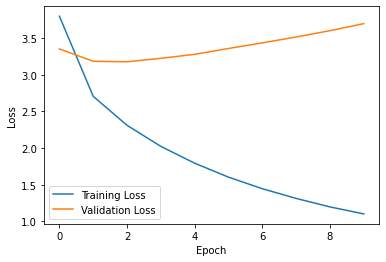

In [136]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 4 Generate predictions on test data [8 marks]

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [137]:
def generate_caption(image_tensor, decoder, train_val_vocab):
    """Generate a caption for the given image using the trained decoder."""
    # Set the decoder to evaluation mode
    decoder.eval()
    
    # Add a batch dimension to the image tensor and move it to the device
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Initialize the hidden and cell states for the decoder
    with torch.no_grad():
        hidden = decoder.init_hidden(1)
        cell = decoder.init_cell(1)
        
        # Initialize the predicted_ids list with the <start> token ID
        predicted_ids = [train_val_vocab('<start>')]
        caption = []

        # Generate the caption one word at a time
        while True:
            # Convert the last predicted ID to a tensor and move it to the device
            inputs = torch.tensor(predicted_ids[-1]).unsqueeze(0).to(device)
            
            # Pass the input, hidden state, cell state, and image through the decoder
            outputs, hidden, cell = decoder(inputs, hidden, cell, image_tensor)
            
            # Choose the word ID with the highest probability
            predicted_id = outputs.argmax(dim=1).item()

            # Stop the generation if the end token is predicted or the caption is too long
            if train_val_vocab.idx2word[predicted_id] == '<end>' or len(caption) >= MAX_SEQ_LEN:
                break
            
            # Append the predicted word to the caption and predicted_ids list
            caption.append(train_val_vocab.idx2word[predicted_id])
            predicted_ids.append(predicted_id)
    
    # Join the predicted words into a single string and return it
    return ' '.join(caption)


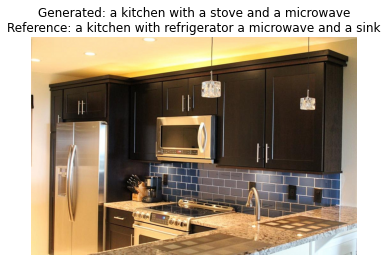

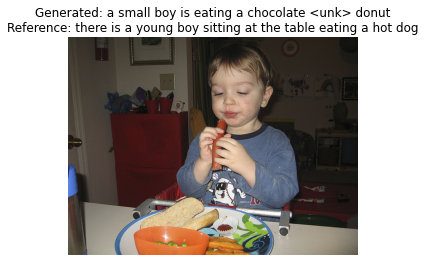

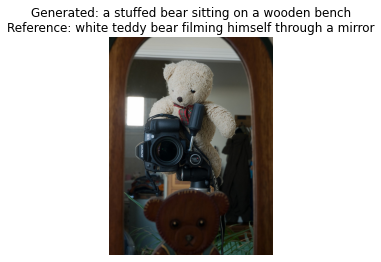

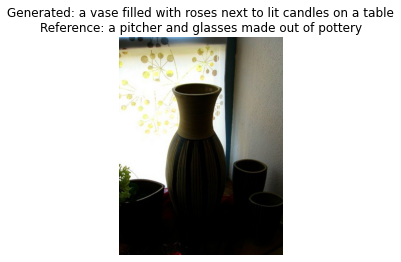

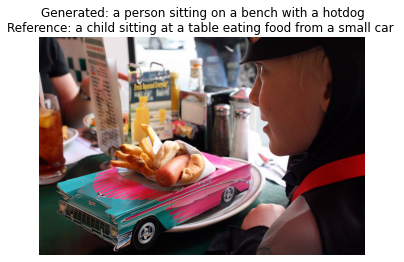

In [139]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def display_image_with_captions(image_path, caption, reference_captions):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Generated: {caption}\nReference: {reference_captions}")
    plt.axis("off")
    plt.show()

# Load the trained model
# decoder.load_state_dict(torch.load('decoder.ckpt'))
# decoder = decoder.to(device)
decoder.eval()

# Number of images to display
num_images = 5

for _ in range(num_images):
    random_image_id = random.choice(test_df_filtered["image_id"].unique())
    selected_image = test_df_filtered[test_df_filtered["image_id"] == random_image_id].iloc[0]
    
    image_path = f"coco/images/{selected_image['file_name']}"
    image_features = torch.from_numpy(loadfeatures_map[random_image_id]).unsqueeze(0).to(device)
    
    # Generate captions
    with torch.no_grad():
        generated_caption = decoder.sample(image_features)
    
    # Convert caption tokens to words
    caption_words = []
    for token in generated_caption.squeeze(0):
        word = train_val_vocab.idx2word[token.item()]
        if word == '<end>':
            break
        caption_words.append(word)
    caption = ' '.join(caption_words)
    
    # Get reference captions
    reference_captions = test_df_filtered[test_df_filtered["image_id"] == random_image_id]["clean_caption"].tolist()
    
    # Display the image with generated and reference captions
    display_image_with_captions(image_path, caption, reference_captions[0])

## 5 Caption evaluation using BLEU score [10 marks]

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

> 5.1 Average BLEU score on all data (5 marks)

> 5.2 Examplaire high and low score BLEU score samples (5 marks, at least two)

####  5.1 Average BLEU score on all data (5 marks)


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions. 

Display a histogram of the distribution of scores over the test set.

Average BLEU score on all test data: 0.0014256785767643417


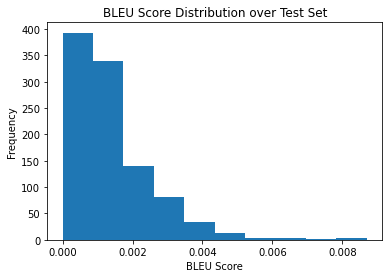

Stats DataFrame:
                                                 ref  \
0  [a bathroom with a poster of an ugly face abov...   
1  [a display of a toilet and sink in a store , a...   
2  [two stuffed animals are cutting bread and spr...   
3  [a kitchen filled with clutter all over it s c...   
4  [a white bathroom with a walk in shower and a ...   

                                              preds      bleu cos_sim  
0               a bathroom with a toilet and a sink  0.001137    None  
1                a kitchen of a kitchen counter top  0.000259    None  
2         a table with two plates of food and <unk>  0.000821    None  
3  a kitchen with a counter with drinks <unk> on it  0.000624    None  
4  a white toilet sitting next to a sink and a sink  0.002674    None  


In [143]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import matplotlib.pyplot as plt

# Initialize BLEU score list and stats DataFrame
bleu_scores = []
stats = pd.DataFrame(columns=['ref', 'preds', 'bleu', 'cos_sim'])

# Loop through the test dataset
for image_id in df_test["image_id"].unique():
    selected_image = df_test[df_test["image_id"] == image_id].iloc[0]
    image_features = torch.from_numpy(loadfeatures_map[image_id]).unsqueeze(0).to(device)
    
    # Generate captions
    with torch.no_grad():
        generated_caption = decoder.sample(image_features)
    
    # Convert caption tokens to words
    caption_words = []
    for token in generated_caption.squeeze(0):
        word = train_val_vocab.idx2word[token.item()]
        if word == '<end>':
            break
        caption_words.append(word)
    generated_caption_text = ' '.join(caption_words)
    
    # Get reference captions
    reference_captions = df_test[df_test["image_id"] == image_id]["clean_caption"].tolist()
    
    # Calculate BLEU score
    smoothing = SmoothingFunction().method4
    bleu_score = sentence_bleu(reference_captions, generated_caption_text.split(), smoothing_function=smoothing)
    bleu_scores.append(bleu_score)
    
    # Add reference captions, predicted caption, and BLEU score to stats DataFrame
    new_row = pd.DataFrame({
        'ref': [reference_captions],
        'preds': [generated_caption_text],
        'bleu': [bleu_score],
        'cos_sim': [None]  # Placeholder for cosine similarity, to be calculated later
    })
    stats = pd.concat([stats, new_row], ignore_index=True)

# Calculate and display average BLEU score
average_bleu_score = np.mean(bleu_scores)
print(f"Average BLEU score on all test data: {average_bleu_score}")

# Display histogram of BLEU score distribution
plt.hist(bleu_scores, bins=10)
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('BLEU Score Distribution over Test Set')
plt.show()

print("Stats DataFrame:")
print(stats.head())






Average BLEU score: 0.0014256785767643423


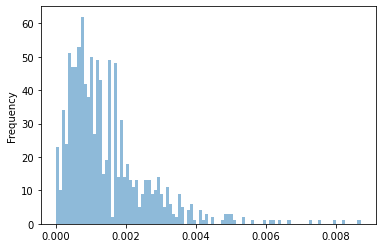

In [153]:
print("Average BLEU score:", stats['bleu'].mean())
ax = stats['bleu'].plot.hist(bins=100, alpha=0.5)

#### 5.2 Examplaire high and low score BLEU score samples (5 marks)

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [ ]:
# TO COMPLETE

In [144]:
# Convert 'bleu' column to a numeric dtype (e.g., float)
stats['bleu'] = stats['bleu'].astype(float)

# Find the indices of the highest and lowest BLEU scores
highest_bleu_idx = stats['bleu'].idxmax()
lowest_bleu_idx = stats['bleu'].idxmin()

# Display the highest BLEU score sample
print("Sample with the highest BLEU score:")
print(f"Predicted caption: {stats.iloc[highest_bleu_idx]['preds']}")
print(f"Reference captions: {stats.iloc[highest_bleu_idx]['ref']}")
print(f"BLEU score: {stats.iloc[highest_bleu_idx]['bleu']}")

print("\n")

# Display the lowest BLEU score sample
print("Sample with the lowest BLEU score:")
print(f"Predicted caption: {stats.iloc[lowest_bleu_idx]['preds']}")
print(f"Reference captions: {stats.iloc[lowest_bleu_idx]['ref']}")
print(f"BLEU score: {stats.iloc[lowest_bleu_idx]['bleu']}")

Sample with the highest BLEU score:
Predicted caption: a living room with a t v and a bunch of books on it
Reference captions: ['a carpeted room with two televisions and speakers', 'some tables and tvs cluttered in a corner with various other items ', 'an image of a living room set with vase', 'a room with big curtains filled with some various items ', 'a living room with a tv a desk and another tv']
BLEU score: 0.008700059528228622


Sample with the lowest BLEU score:
Predicted caption: two giraffes are standing next to each other
Reference captions: ['two tall giraffe standing next to a green leaf filled tree', 'three giraffe s in a green field of grass ', 'some animals that are sitting under a tree ', 'there giraffes all around a large green tree ', 'three giraffes lounging under a large tree relaxing ']
BLEU score: 0.0


## 6 Caption evaluation using cosine similarity [12 marks]

> 6.1 Cosine similarity (6 marks)

> 6.2 Cosine similarity examples (6 marks)

####  6.1 Cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

In [ ]:
# TO COMPLETE

In [146]:
# TO COMPLETE
# TO COMPLETE
import requests
import zipfile
import os

# Run this function only for the first time to download and extract glove vector embeddings
def download_and_extract_glove(url, destination):
    response = requests.get(url, stream=True)
    with open(destination, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    with zipfile.ZipFile(destination, 'r') as zip_ref:
        zip_ref.extractall()

glove_url = 'http://nlp.stanford.edu/data/glove.6B.zip'
glove_destination = 'glove.6B.zip'

if not os.path.exists('glove.6B.300d.txt'):
    download_and_extract_glove(glove_url, glove_destination)

In [147]:
def load_embeddingsofglove(file):
    embeddings = {}
    with open(file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_embeddingsofglove('glove.6B.300d.txt')

Average cosine similarity score on all test data: 0.8337298631668091


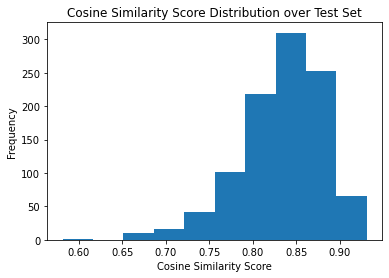

In [151]:
from sklearn.metrics.pairwise import cosine_similarity

def get_average_embedding(caption, embeddings):
    words = caption.split()
    vecs = [embeddings[word] for word in words if word in embeddings]
    if not vecs:
        return np.zeros(300)  # Return a zero-vector if no words are found in the embeddings
    return np.mean(vecs, axis=0)

cos_sim_scores = []
for index, row in stats.iterrows():
    pred_avg_embed = get_average_embedding(row['preds'], glove_embeddings)
    ref_avg_embeds = [get_average_embedding(ref, glove_embeddings) for ref in row['ref']]
    
    cos_similarity = [cosine_similarity(pred_avg_embed.reshape(1, -1), ref_avg_embed.reshape(1, -1))[0][0] for ref_avg_embed in ref_avg_embeds]
    avg_cos_sim = np.mean(cos_similarity)
    cos_sim_scores.append(avg_cos_sim)

    # Update the 'cos_sim' column in the stats DataFrame
    stats.at[index, 'cos_sim'] = avg_cos_sim

# Calculate and display average cosine similarity score
average_cos_sim_score = np.mean(cos_sim_scores)
print(f"Average cosine similarity score on all test data: {average_cos_sim_score}")

# Display histogram of cosine similarity score distribution
plt.hist(cos_sim_scores, bins=10)
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency') 
plt.title('Cosine Similarity Score Distribution over Test Set')
plt.show()

#### 6.2 Cosine similarity examples (6 marks)

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

In [ ]:
# TO COMPLETE

In [152]:
# Sort the stats DataFrame by cosine similarity
sorted_stats = stats.sort_values(by='cos_sim')

# Display the sample with the lowest cosine similarity score
lowest_cosine_sim_sample = sorted_stats.iloc[0]
print("Sample with the lowest cosine similarity score:")
print(f"Predicted caption: {lowest_cosine_sim_sample['preds']}")
print(f"Cosine similarity score: {lowest_cosine_sim_sample['cos_sim']}")
print("Reference captions:")
for i, ref in enumerate(lowest_cosine_sim_sample['ref']):
    print(f"{i + 1}: {ref}")

print("\n")

# Display the sample with the highest cosine similarity score
highest_cosine_sim_sample = sorted_stats.iloc[-1]
print("Sample with the highest cosine similarity score:")
print(f"Predicted caption: {highest_cosine_sim_sample['preds']}")
print(f"Cosine similarity score: {highest_cosine_sim_sample['cos_sim']}")
print("Reference captions:")
for i, ref in enumerate(highest_cosine_sim_sample['ref']):
    print(f"{i + 1}: {ref}")

Sample with the lowest cosine similarity score:
Predicted caption: a man in the back of a person riding a skateboard
Cosine similarity score: 0.5813663601875305
Reference captions:
1: baggage handlers are an airport loading luggage onto a plane 
2: baggage handlers are an airport loading luggage onto a plane 
3: three airport workers loading luggage onto the truck 
4: three airport workers loading luggage onto the truck 
5: luggage handlers unloading many suitcases at an airport 
6: luggage handlers unloading many suitcases at an airport 
7: airport baggage handlers loading luggage into a cart 
8: airport baggage handlers loading luggage into a cart 
9: three young men are piling luggage into a storage container
10: three young men are piling luggage into a storage container


Sample with the highest cosine similarity score:
Predicted caption: a large bus is parked on a city street
Cosine similarity score: 0.9309449791908264
Reference captions:
1: a large passenger bus parked on a city

## 7 Comparing BLEU and Cosine similarity [16 marks]

> 7.1 Test set distribution of scores (6 marks)

> 7.2 Analysis of individual examples (10 marks)

#### 7.1 Test set distribution of scores (6 marks)

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below). 

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [ ]:
# TO COMPLETE

Average BLEU score on all test data: 0.0014256785767643423 (±0.0011609047701457485)
Average scaled cosine similarity score on all test data: 0.9168649428877337 (±0.024113653740963702)


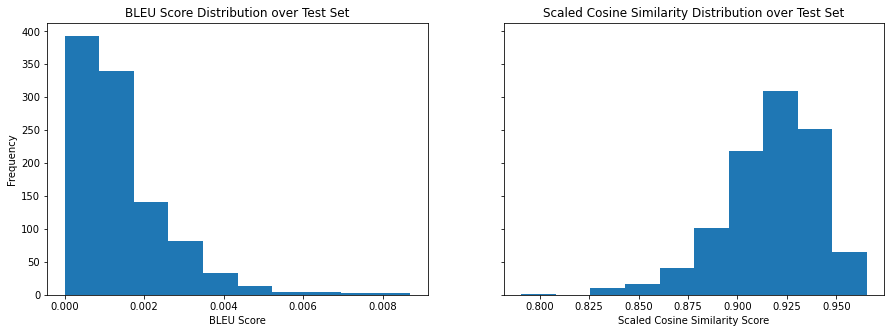

In [155]:
scaled_cosine_sim=(stats['cos_sim']+1)/2
# Calculate average and standard deviation of BLEU and cosine similarity scores
average_bleu_score = np.mean(stats['bleu'])
std_bleu_score = np.std(stats['bleu'])
average_scaled_cosine_sim = np.mean(scaled_cosine_sim)
std_scaled_cosine_sim = np.std(scaled_cosine_sim)

# Display average scores and standard deviations
print(f"Average BLEU score on all test data: {average_bleu_score} (±{std_bleu_score})")
print(f"Average scaled cosine similarity score on all test data: {average_scaled_cosine_sim} (±{std_scaled_cosine_sim})")

# Visualize the distribution of BLEU and cosine similarity scores using histograms
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Plot BLEU score histogram
axs[0].hist(stats['bleu'], bins=10)
axs[0].set_title('BLEU Score Distribution over Test Set')
axs[0].set_xlabel('BLEU Score')
axs[0].set_ylabel('Frequency')

# Plot scaled cosine similarity score histogram
axs[1].hist(scaled_cosine_sim, bins=10)
axs[1].set_title('Scaled Cosine Similarity Distribution over Test Set')
axs[1].set_xlabel('Scaled Cosine Similarity Score')

plt.show()

 #### 7.2 Analysis of individual examples (10 marks)
 
Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

In [ ]:
# TO COMPLETE

In [158]:
similarscore_index = stats.iloc[((stats['bleu'] - average_bleu_score)**2 + (scaled_cosine_sim - average_scaled_cosine_sim)**2).argsort()[:1]]
print("Example with scores closest to the overall average:")
print(f"Predicted caption: {similarscore_index['preds'].values[0]}")
print(f"BLEU score: {similarscore_index['bleu'].values[0]}")
print(f"Scaled cosine similarity score: {similarscore_index['cos_sim'].values[0]}")
print("Reference captions:")
for i, ref in enumerate(similarscore_index['ref'].values[0]):
    
    print(f"{i + 1}: {ref}")
    print("\n")

Example with scores closest to the overall average:
Predicted caption: a man flying a kite over a basketball <unk>
BLEU score: 0.0013501277877579565
Scaled cosine similarity score: 0.8341501951217651
Reference captions:
1: people flying kites with a large pink kite at the forefront 


2: some people on a beach flying their kites


3: a man flying a kite on the beach next to other people 


4: a man flying a pink kite on the beach 


5: people on a beach flying kites and having fun




In [161]:
dissimilarscore_index = stats.iloc[(stats['bleu'] - scaled_cosine_sim).abs().argsort()[-1:]]
print("Example with largest difference in scores:")
print(f"Predicted caption: {dissimilarscore_index['preds'].values[0]}")
print(f"BLEU score: {dissimilarscore_index['bleu'].values[0]}")
print(f"Scaled cosine similarity score: {dissimilarscore_index['cos_sim'].values[0]}")
print("Reference captions:")
for i, ref in enumerate(dissimilarscore_index['ref'].values[0]):
    print(f"{i + 1}: {ref}")

Example with largest difference in scores:
Predicted caption: a tennis player stretching to hit a ball
BLEU score: 0.0007058730503133131
Scaled cosine similarity score: 0.9307841062545776
Reference captions:
1: a tennis player is trying to hit the ball 
2: a tennis player is trying to hit the ball 
3: a tennis player hits a tennis ball behind him 
4: a tennis player hits a tennis ball behind him 
5: a person leaping for a tennis ball with a racquet in their hand 
6: a person leaping for a tennis ball with a racquet in their hand 
7: a boy tennis player running after a tennis ball 
8: a boy tennis player running after a tennis ball 
9: a man hitting a ball on a tennis court 
10: a man hitting a ball on a tennis court 
